<a href="https://colab.research.google.com/github/ibacaraujo/self-supervision-fastai/blob/master/self_supervised_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervised Learning with fast.ai

### Install fast.ai2

In [3]:
!pip install fastai2

### Import libraries

In [0]:
from fastai2.vision.all import *

### Define architecture and model

In [0]:
def simple_arch(pretrained=False):
  model = nn.Sequential(
      nn.Conv2d(1, 4, 3, 1),
      nn.BatchNorm2d(4),
      nn.ReLU(),
      nn.Conv2d(4, 16, 3, 1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, 1),
      nn.BatchNorm2d(32),
      nn.AdaptiveAvgPool2d(1),
  )
  if (pretrained):
    print("Loading pretrained model...")
    pretrained_weights = torch.load(save_path/'rot_pretrained.pt')
    print(model.load_state_dict(pretrained_weights))
  return model

In [6]:
body = create_body(arch=simple_arch, pretrained=False)
body

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [7]:
head = create_head(nf=32*2, n_out=8, lin_ftrs=[])
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=64, out_features=8, bias=False)
)

In [8]:
model = create_cnn_model(arch=simple_arch, pretrained=False, n_out=8, lin_ftrs=[])
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=8, bias=False)
  )
)

### PyTorch Dataset

In [0]:
import torchvision
tensor_to_image = torchvision.transforms.ToPILImage()
image_to_tensor = torchvision.transforms.ToTensor()

In [10]:
torchvision.datasets.MNIST('/content/drive/My Drive/fastai2/data/', download='True')

Extracting /content/drive/My Drive/fastai2/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/fastai2/data/MNIST/raw


Extracting /content/drive/My Drive/fastai2/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/fastai2/data/MNIST/raw


Extracting /content/drive/My Drive/fastai2/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/fastai2/data/MNIST/raw




Extracting /content/drive/My Drive/fastai2/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/fastai2/data/MNIST/raw
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/fastai2/data/
    Split: Train

In [0]:
class Custom_Dataset_MNIST():
  '''
  A Dataset for Rotation-based Self-supervision! Images are rotated clockwise
  - file - MNIST processed .pt file
  - pct - percent of data to use
  - classification - False = Use rotation labels. True = Use classification labels
  '''

  def __init__(self, file, pct, classification):
    
    data = torch.load(file)
    self.imgs = data[0]
    self.labels = data[1]
    self.pct = pct
    self.classification = classification

    slice_idx = int(len(self.imgs)*self.pct)
    self.imgs = self.imgs[:slice_idx]

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx].unsqueeze(0)
    img = tensor_to_image(img)
    img = img.resize((32, 32), resample=1)
    img = image_to_tensor(img)

    if (not self.classification):
      degrees = [0, 45, 90, 135, 180, 225, 270, 315]
      rand_choice = random.randint(0, len(degrees)-1)

      img = tensor_to_image(img)
      img = img.rotate(degrees[rand_choice])
      img = image_to_tensor(img)

      return img, torch.tensor(rand_choice).long()

    return img, self.labels[idx]

  def show_batch(self, n=3):
    fig, axs = plt.subplots(n, n)
    fig.tight_layout()
    for i in range(n):
      for j in range(n):
        rand_idx = random.randint(0, len(self)-1)
        img, label = self.__getitem__(rand_idx)
        axs[i, j].imshow(tensor_to_image(img), cmap='gray')
        if self.classification:
          axs[i, j].set_title('Label: {0} (Digit #{1})'.format(label.item(), label.item()))
        else:
          axs[i, j].set_title('Label: {0} (Digit #{1})'.format(label.item(), label.item()*45))
        axs[i, j].axis('off')


### Rotation Prediction Data

In [17]:
train_ds = Custom_Dataset_MNIST('/content/drive/My Drive/fastai2/data/MNIST/processed/training.pt', pct=1.0, classification=False)
valid_ds = Custom_Dataset_MNIST('/content/drive/My Drive/fastai2/data/MNIST/processed/test.pt', pct=1.0, classification=False)
print('{0} Training Samples | {1} Validation samples'.format(len(train_ids), len(valid_ids)))

60000 Training Samples | 10000 Validation samples


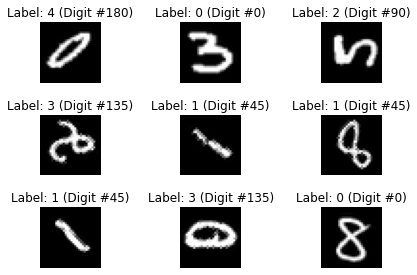

In [18]:
from fastai2.data.core import DataLoaders

dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda()

dls.show_batch = train_ds.show_batch # overwrite show_batch to custom one

dls.c = 8 # we have 8 classes that correspond to the degrees

dls.show_batch()

### Vision learner for rotation

In [19]:
head_config = cnn_config(lin_ftrs=[])
head_config

{'lin_ftrs': []}

In [20]:
# considering top_2 accuracy because there are hard cases regarding rotation
top_2_accuracy = lambda inp, targ: top_k_accuracy(inp, targ, k=2)
top_2_accuracy

<function __main__.<lambda>>

In [21]:
learner = cnn_learner(dls, # DataLoaders
                      simple_arch, # Architecture
                      pretrained=False,
                      loss_func=CrossEntropyLossFlat(),
                      config=head_config,
                      metrics=[accuracy, top_2_accuracy])
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=8, bias=False)
  )
)

In [22]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         True      
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        True      
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      True      
___________________________________________________

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.03981071710586548)

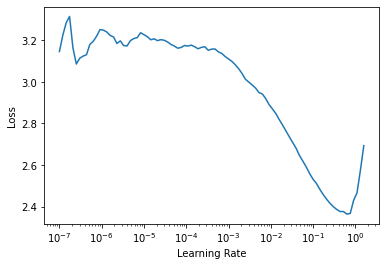

In [23]:
learner.lr_find()

In [24]:
learner.fit_one_cycle(5, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,,time
0,0.933702,1.062118,0.510400,0.861700,00:31
1,0.838607,3.168929,0.357600,0.669500,00:31
2,0.723769,4.822454,0.360200,0.703700,00:31
3,0.628014,7.522727,0.290900,0.447400,00:31
4,0.573693,0.486593,0.794200,0.971400,00:31


In [25]:
# Great. Now we want to grab our model from our Learner, and save the body of it
trained_body = learner.model[0]
trained_body

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [0]:
save_path = Path('/content/drive/My Drive/fastai2/rotation_cps/')
if not save_path.exists():
  save_path.mkdir()

# Save the rotation-pretraining weights of our model body
torch.save(trained_body.state_dict(), save_path/'rot_pretrained.pt')

### Original Classification Data

In [31]:
# Switch over to the original labeled data for classification
# IMPORTANT. We're only using 180 samples for training.
train_ds = Custom_Dataset_MNIST('/content/drive/My Drive/fastai2/data/MNIST/processed/training.pt', pct=0.003, classification=True)
valid_ds = Custom_Dataset_MNIST('/content/drive/My Drive/fastai2/data/MNIST/processed/test.pt', pct=1.0, classification=True)
print('{0} Training Samples | {1} Validation Samples'.format(len(train_ds), len(valid_ds)))

180 Training Samples | 10000 Validation Samples


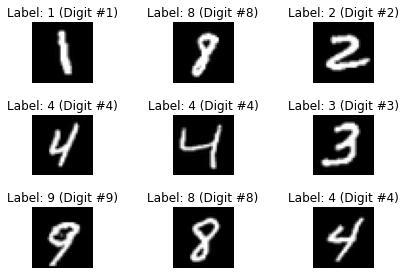

In [32]:
from fastai2.data.core import DataLoaders

dls = DataLoaders.from_dsets(train_ds, valid_ds)
dls.show_batch = train_ds.show_batch

dls.c = 10

dls.show_batch()

### Vision learner for transfer-classification

In [33]:
# pretrained=True will load the saved rotation pretrainining weights into model
# this is the simple_arch() function definition, it loads the file.
learner = cnn_learner(dls,
                      simple_arch,
                      pretrained=True,
                      loss_func=CrossEntropyLossFlat(),
                      config=head_config,
                      metrics=[accuracy])
learner.model

Loading pretrained model...
<All keys matched successfully>


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=False)
  )
)

In [0]:
learner.freeze() # freeze the body, pretrained

In [35]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         False     
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        False     
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      False     
___________________________________________________

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.05754399299621582)

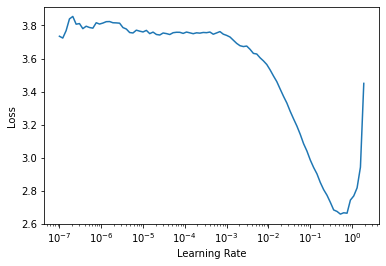

In [36]:
learner.lr_find()

In [37]:
learner.fit_one_cycle(10, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.733802,3.722608,0.102800,00:05
1,3.501722,3.182457,0.102900,00:05
2,3.208414,3.119099,0.122200,00:05
3,2.924920,2.910953,0.156700,00:05
4,2.681373,2.721081,0.172000,00:05
5,2.450458,2.541841,0.245000,00:05
6,2.277218,2.308508,0.270600,00:05
7,2.121537,2.099858,0.298500,00:05
8,2.004285,1.915741,0.335600,00:05
9,1.889849,1.780284,0.391500,00:05


In [0]:
# Unfreeze the model after calibrating the new head with the transferred body
# Train a little more so
learner.unfreeze()

In [39]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         True      
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        True      
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      True      
___________________________________________________

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.12022644281387329)

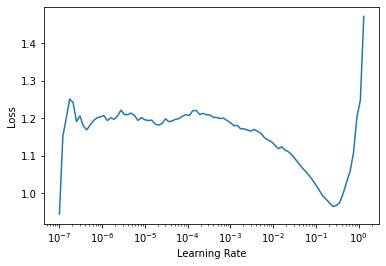

In [40]:
learner.lr_find()

In [41]:
learner.fine_tune(5, base_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.383217,1.656755,0.447900,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.022671,1.573407,0.487700,00:05
1,1.067793,1.495424,0.522500,00:05
2,1.055647,1.429193,0.552500,00:05
3,1.067986,1.379625,0.570400,00:05
4,1.024350,1.346490,0.580300,00:05


61.7% accuracy using transfer learning from our pretraining on the rotation prediction task

### Vision learner from scratch-classification

In [42]:
# Using the same 180 labeled data
learner = cnn_learner(dls,
                      simple_arch,
                      pretrained=False,
                      loss_func=CrossEntropyLossFlat(),
                      config=head_config,
                      metrics=[accuracy])
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=False)
  )
)

In [43]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         True      
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        True      
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      True      
___________________________________________________

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.005248074419796467)

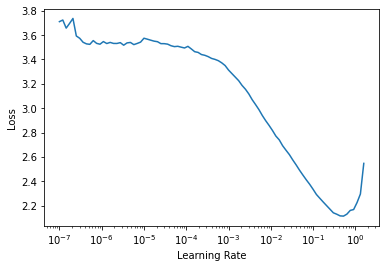

In [44]:
learner.lr_find()

In [45]:
learner.fit_one_cycle(10, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.567303,2.393401,0.105300,00:05
1,2.935095,2.490094,0.113500,00:05
2,2.648732,3.037244,0.113500,00:05
3,2.410326,4.138296,0.113500,00:05
4,2.212268,5.834351,0.113500,00:05
5,2.051669,6.624345,0.113500,00:05
6,1.905902,6.952027,0.113500,00:05
7,1.788167,6.924798,0.113500,00:05
8,1.695617,6.941276,0.113500,00:05
9,1.619571,6.835559,0.113500,00:05


11% accuracy with training from scratch

### Conclusion

I got it!

Rotation prediction was used as a pretext task for feature representation learning.